# Hello, Numerai

Hello and welcome to the Numerai Data Science Tournament!

This notebook is designed to help you build your first machine learning model and start competing the tournament.

In this notebook we will
1. Download and explore the Numerai dataset
2. Train and evaluate your first machine learning model
3. Deploy your model to start making live submissions

In [ ]:
!python --version


In [ ]:
!pip install numpy==1.23.5 scipy==1.10.1

In [ ]:
!pip install lightgbm==4.0.0

In [ ]:
!pip install numerapi==2.15.0 pandas==2.0.0 pyarrow==11.0.0 matplotlib==3.7.1 scikit-learn==1.2.2 cloudpickle==2.2.1 xgboost==1.7.5

In [ ]:
# 1) Install and initialize Ray Tune
!pip install -q "ray[tune]" -U

In [2]:
# Inline plots
%matplotlib inline

In [ ]:
!pip install absl-py==1.4.0
aiohttp==3.8.4
aiosignal==1.3.1
astunparse==1.6.3
async-timeout==4.0.2
attrs==23.1.0
cachetools==5.3.1
catboost==1.2
certifi==2022.12.7
charset-normalizer==3.1.0
click==8.1.3
cloudpickle==2.2.1
contourpy==1.0.7
cycler==0.11.0
fickling==0.0.4
filelock==3.12.0
flatbuffers==23.5.26
fonttools==4.39.4
frozenlist==1.3.3
fsspec==2023.5.0
gast==0.4.0
google-auth==2.19.1
google-auth-oauthlib==1.0.0
google-pasta==0.2.0
graphviz==0.20.1
grpcio==1.54.2
h5py==3.8.0
idna==3.4
jax==0.4.11
Jinja2==3.1.2
joblib==1.2.0
keras==2.15.0
kiwisolver==1.4.4
libclang==16.0.0
lightgbm==4.0.0
lightning-utilities==0.8.0
Markdown==3.4.3
MarkupSafe==2.1.3
matplotlib==3.7.1
ml-dtypes==0.2.0
mlxtend==0.23.1
mpmath==1.3.0
multidict==6.0.4
networkx==3.1
numerapi==2.15.0
numerblox==0.5.9
numpy==1.23.5
oauthlib==3.2.2
opt-einsum==3.3.0
packaging==23.1
pandas==2.0.0
Pillow==9.5.0
plotly==5.14.1
polars==0.18.15
protobuf==4.23.2
pyarrow==11.0.0
pyasn1==0.5.0
pyasn1-modules==0.3.0
pyparsing==3.0.9
python-dateutil==2.8.2
pytorch-lightning==2.0.2
pytz==2023.3
PyYAML==6.0
requests==2.32.3
requests-oauthlib==1.3.1
rsa==4.9
scikit-learn==1.2.2
scipy==1.10.1
six==1.16.0
statsmodels==0.14.1
sympy==1.12
tenacity==8.2.2
tensorboard==2.15.0
tensorboard-data-server==0.7.2
tensorflow==2.15.0
tensorflow-decision-forests==1.8.1
tensorflow-estimator==2.15.0
tensorflow-io-gcs-filesystem==0.34.0
termcolor==2.3.0
threadpoolctl==3.1.0
torch==2.0.1
torchmetrics==0.11.4
tqdm==4.65.0
treelite==3.9.1
treelite-runtime==3.9.1
typing_extensions==4.6.3
tzdata==2023.3
urllib3==1.26.19
Werkzeug==2.3.4
wrapt==1.14.1
xgboost==1.7.5
yarl==1.9.2

In [3]:
import numpy
import pandas
print(f"NumPy version: {numpy.__version__}")
print(f"Pandas version: {pandas.__version__}")

NumPy version: 1.23.5
Pandas version: 2.2.2


## 1. Dataset  

At a high level, the Numerai dataset is a tabular dataset that describes the stock market over time. It is compiled from high-quality (and expensive) data that might be difficult for individuals to obtain.

The unique thing about Numerai's dataset is that it is `obfuscated`, which means that the underlying stock ids, feature names, and target definitions are anonymized. This makes it so that we can give this data out for free and so that it can be modeled without any financial domain knowledge (or bias!).

### Listing the datasets
Firstly, take a look at the files Numerai offers below:

In [5]:
# Initialize NumerAPI - the official Python API client for Numerai
from numerapi import NumerAPI
napi = NumerAPI(public_id=userdata.get('NUMERAI_PUBLICID'), secret_key=userdata.get('NUMERAI_SECRET'))

# list the datasets and available versions
all_datasets = napi.list_datasets()
dataset_versions = list(set(d.split('/')[0] for d in all_datasets))
print("Available versions:\n", dataset_versions)

# Set data version to one of the latest datasets
DATA_VERSION = "v5.0"

# Print all files available for download for our version
current_version_files = [f for f in all_datasets if f.startswith(DATA_VERSION)]
print("Available", DATA_VERSION, "files:\n", current_version_files)

ModuleNotFoundError: No module named 'numerapi'

### Downloading datasets

The `features.json` file contains metadata about features in the dataset including:
- statistics on each feature
- helpful sets of features
- the targets available for training

Let's download it and take a look:

In [5]:
import json

# download the feature metadata file
napi.download_dataset(f"{DATA_VERSION}/features.json")

# read the metadata and display
feature_metadata = json.load(open(f"{DATA_VERSION}/features.json"))
for metadata in feature_metadata:
  print(metadata, len(feature_metadata[metadata]))

v5.0/features.json: 291kB [00:00, 558kB/s]                           

feature_sets 17
targets 37


### Feature Sets & Groups
As you can see there are many features and targets to choose from.

Instead of training a model on all 2000+ features, let's pick a subset of features to analyze.

Here are a few starter sets Numerai offers:

- `small` contains a minimal subset of features that have the highest [feature importance](https://scikit-learn.org/stable/auto_examples/ensemble/plot_forest_importances.html)

- `medium` contains all the "basic" features, each unique in some way (e.g. P/E ratios vs analyst ratings)

- `all` contains all features in `medium` and their variants (e.g. P/E by country vs P/E by sector)

Let's take a look at the medium feature set:

In [6]:
feature_sets = feature_metadata["feature_sets"]
for feature_set in ["small", "medium", "all"]:
  print(feature_set, len(feature_sets[feature_set]))

small 42
medium 705
all 2376



The `medium` set seems much more reasonable.

Using it will speed up model training and reduce memory usage (required for Colab free tier).

Let's load the training data for just the medium feature set:

In [7]:
import pandas as pd

# Define our feature set
feature_set = feature_sets["small"]
# use "medium" or "all" for better performance. Requires more RAM.
# features = feature_metadata["feature_sets"]["medium"]
# features = feature_metadata["feature_sets"]["all"]

# Download the training data - this will take a few minutes
napi.download_dataset(f"{DATA_VERSION}/train.parquet")

# Load only the "medium" feature set to
# Use the "all" feature set to use all features
train = pd.read_parquet(
    f"{DATA_VERSION}/train.parquet",
    columns=["era", "target"] + feature_set
)

# Downsample to every 4th era to reduce memory usage and speedup model training (suggested for Colab free tier)
# Comment out the line below to use all the data
train = train[train["era"].isin(train["era"].unique()[::4])]

v5.0/train.parquet: 2.37GB [04:19, 9.13MB/s]                            



### Training data

Each row represents a stock at a specific point in time:
- `id` is the stock id
- `era` is the date
- `target` is a measure of future returns for that stock
- `features` describe the attributes of the stock (eg. P/E ratio) for that date

In [8]:
train

,era,target,feature_antistrophic_striate_conscriptionist,feature_bicameral_showery_wallaba,feature_bridal_fingered_pensioner,feature_collectivist_flaxen_gueux,feature_concurring_fabled_adapter,feature_crosscut_whilom_ataxy,feature_departmental_inimitable_sentencer,feature_dialectal_homely_cambodia,...,feature_tridactyl_immoral_snorting,feature_trimeter_soggy_greatest,feature_unanalyzable_excusable_whirlwind,feature_unbreakable_constraining_hegelianism,feature_unformed_bent_smatch,feature_unministerial_unextenuated_teleostean,feature_unmodish_zymogenic_rousing,feature_unsystematized_subcardinal_malaysia,feature_willful_sere_chronobiology,feature_zoological_peristomial_scute
id,,,,,,,,,,,,,,,,,,,,,
n0007b5abb0c3a25,0001,0.25,2,2,2,2,2,0,1,2,...,4,1,1,3,0,2,2,3,3,2
n003bba8a98662e4,0001,0.25,2,2,2,2,2,1,4,2,...,4,2,0,0,0,2,2,4,4,2
n003bee128c2fcfc,0001,0.75,2,2,2,2,2,2,2,2,...,3,1,1,0,1,2,2,0,3,2
n0048ac83aff7194,0001,0.25,2,2,2,2,2,1,4,2,...,1,3,4,1,2,2,2,2,0,2
n0055a2401ba6480,0001,0.25,2,2,2,2,2,0,0,2,...,1,0,1,0,0,2,2,1,4,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
nffc2d5e4b79a7ae,0573,0.00,1,2,1,0,3,2,1,1,...,2,2,1,2,3,3,3,2,2,1
nffc9844c1c7a6a9,0573,0.25,2,1,2,1,4,2,2,4,...,4,0,0,3,1,3,3,2,3,2
nffd79773f4109bb,0573,0.50,3,4,0,3,4,1,0,1,...,3,0,0,0,1,1,4,0,1,2


### Eras
As mentioned above, each `era` corresponds to a different date. Each era is exactly 1 week apart.

It is helpful to think about rows of stocks within the same `era` as a single example. You will notice that throughout this notebook and other examples, we often talk about things "per era". For example, the number of rows per era represents the number of stocks in Numerai's investable universe on that date.

<Axes: title={'center': 'Number of rows per era'}, xlabel='Era'>

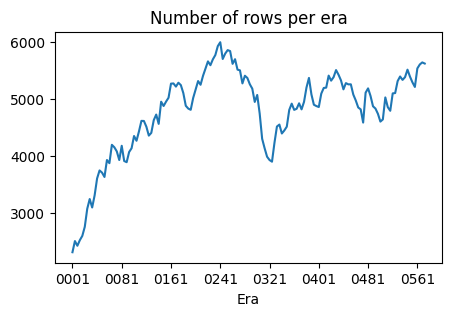

In [9]:
# Plot the number of rows per era
train.groupby("era").size().plot(
    title="Number of rows per era",
    figsize=(5, 3),
    xlabel="Era"
)

### Target
The `target` is a measure of stock market returns over the next 20 (business) days. Specifically, it is a measure of "stock-specific" returns that are not explained by well-known "factors" or broader trends in the market, country, or sector. For example, if Apple went up and the tech sector also went up, we only want to know if Apple went up more or less than the tech sector.

Target values are binned into 5 unequal bins: `0`, `0.25`, `0.5`, `0.75`, `1.0`. Again, this heavy regularization of target values is to avoid overfitting as the underlying values are extremely noisy.

<Axes: title={'center': 'Target'}, xlabel='Value', ylabel='Frequency'>

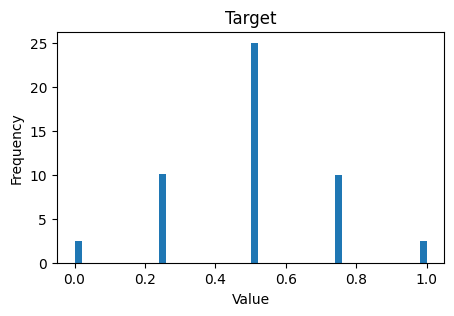

In [10]:
# Plot density histogram of the target
train["target"].plot(
  kind="hist",
  title="Target",
  figsize=(5, 3),
  xlabel="Value",
  density=True,
  bins=50
)

### Features
The `features` are quantitative attributes of each stock: fundamentals like P/E ratio, technical signals like RSI, market data like short interest, secondary data like analyst ratings, and much more.

The underlying definition of each feature is not important, just know that Numerai has included these features in the dataset because we believe they are predictive of the `target` either by themselves or in combination with other features.

Feature values are binned into 5 equal bins: `0`, `1`, `2`, `3`, `4`. This heavy regularization of feature values is to avoid overfitting as the underlying values are extremely noisy. Unlike the target, these are integers instead of floats to reduce the storage needs of the overall dataset.

If data for a particular feature is missing for that era (more common in early `eras`), then all values will be set to `2`.

<Axes: title={'center': 'missing data'}, ylabel='Frequency'>

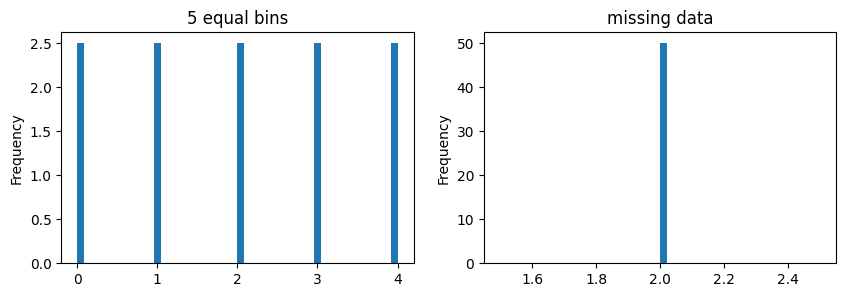

In [11]:
import matplotlib.pyplot as plt
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 3))
first_era = train[train["era"] == train["era"].unique()[0]]
last_era = train[train["era"] == train["era"].unique()[-1]]
last_era[feature_set[-1]].plot(
   title="5 equal bins",
   kind="hist",
   density=True,
   bins=50,
   ax=ax1
)
first_era[feature_set[-1]].plot(
   title="missing data",
   kind="hist",
   density=True,
   bins=50,
   ax=ax2
)

## 2. Modeling
At a high level, our task is to model and predict the `target` using the `features`.

### Model training

You are free to use any tool or framework, but here we will be using LGBMRegressor, a popular choice amongst tournament participants. While you wait for the model to train, watch this [video](https://www.youtube.com/watch?v=w8Y7hY05z7k) to learn why tree-based models work so well on tabular datasets from our Chief Scientist MDO.

In [ ]:
X = train[feature_set]
y = train["target"]

In [19]:
# 0) At the *very top* of your tuning cell, kill any stray Ray and start fresh:
import ray
ray.shutdown()                          # make sure old sessions are gone
ray.init(num_cpus=4, num_gpus=1)        # one and only one init
print("Ray resources:", ray.available_resources())


2025-05-04 06:09:52,683	INFO worker.py:1888 -- Started a local Ray instance.


Ray resources: {'node:__internal_head__': 1.0, 'CPU': 4.0, 'object_store_memory': 16312920883.0, 'node:172.28.0.12': 1.0, 'memory': 38063482061.0, 'GPU': 1.0, 'accelerator_type:T4': 1.0}


In [20]:
import ray
from ray import tune
from ray.tune import with_parameters
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from math import sqrt

# 2) Split once
X = train[feature_set]; y = train["target"]
X_train, X_valid, y_train, y_valid = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# 1) wrap as a pure function
def train_xgb_gpu(config, X_train, y_train, X_valid, y_valid):
    model = XGBRegressor(
        tree_method="hist",    # the new default CPU/GPU‐accelerator
        device="cuda",         # tells XGBoost to run on your T4
        **config,
        random_state=42,
        n_jobs=1,              # parallelism is on the GPU
    )
    model.fit(
        X_train,
        y_train,
        eval_set=[(X_valid, y_valid)],
        verbose=False,
    )
    preds = model.predict(X_valid)
    rmse = sqrt(mean_squared_error(y_valid, preds))

    # <-- note the dict form here
    tune.report({"rmse": rmse})

# 2) scatter your data into Ray under the same session
trainable = with_parameters(
    train_xgb_gpu,
    X_train=X_train, y_train=y_train,
    X_valid=X_valid, y_valid=y_valid,
)

# 4) run Tune requesting 1 GPU per trial
analysis = tune.run(
    trainable,
    config=param_space,
    num_samples=50,
    resources_per_trial={"cpu": 4, "gpu": 1},
    metric="rmse",
    mode="min",
)


print("Best config:", analysis.get_best_config(metric="rmse", mode="min"))

# 7) Retrain final on all data
best_cfg = analysis.get_best_config(metric="rmse", mode="min")
model = XGBRegressor(tree_method="gpu_hist", gpu_id=0, **best_cfg, random_state=42)
model.fit(X, y)


+----------------------------------------------------------------------+
| Configuration for experiment     train_xgb_gpu_2025-05-04_06-10-08   |
+----------------------------------------------------------------------+
| Search algorithm                 BasicVariantGenerator               |
| Scheduler                        FIFOScheduler                       |
| Number of trials                 50                                  |
+----------------------------------------------------------------------+

View detailed results here: /root/ray_results/train_xgb_gpu_2025-05-04_06-10-08
To visualize your results with TensorBoard, run: `tensorboard --logdir /tmp/ray/session_2025-05-04_06-09-51_555141_2098/artifacts/2025-05-04_06-10-08/train_xgb_gpu_2025-05-04_06-10-08/driver_artifacts`

Trial status: 50 PENDING
Current time: 2025-05-04 06:10:08. Total running time: 0s
Logical resource usage: 4.0/4 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:T4)
+--------------------------------------------

(train_xgb_gpu pid=9553) [06:10:14] WARNING: /workspace/src/common/error_msg.cc:58: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
(train_xgb_gpu pid=9553) Potential solutions:
(train_xgb_gpu pid=9553) - Use a data structure that matches the device ordinal in the booster.
(train_xgb_gpu pid=9553) - Set the device for booster before call to inplace_predict.
(train_xgb_gpu pid=9553) 
(train_xgb_gpu pid=9553) This warning will only be shown once.
(train_xgb_gpu pid=9553) 



Trial train_xgb_gpu_6e105_00000 finished iteration 1 at 2025-05-04 06:10:14. Total running time: 6s
+----------------------------------------------------+
| Trial train_xgb_gpu_6e105_00000 result             |
+----------------------------------------------------+
| checkpoint_dir_name                                |
| time_this_iter_s                           3.88258 |
| time_total_s                               3.88258 |
| training_iteration                               1 |
| rmse                                       0.22332 |
+----------------------------------------------------+

Trial train_xgb_gpu_6e105_00000 completed after 1 iterations at 2025-05-04 06:10:14. Total running time: 6s

Trial train_xgb_gpu_6e105_00001 started with configuration:
+----------------------------------------------------+
| Trial train_xgb_gpu_6e105_00001 config             |
+----------------------------------------------------+
| colsample_bytree                           0.61293 |
| gamma       

(train_xgb_gpu pid=9681) 
(train_xgb_gpu pid=9681) 
(train_xgb_gpu pid=9681) [06:10:23] WARNING: /workspace/src/common/error_msg.cc:58: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
(train_xgb_gpu pid=9681) Potential solutions:
(train_xgb_gpu pid=9681) - Use a data structure that matches the device ordinal in the booster.
(train_xgb_gpu pid=9681) - Set the device for booster before call to inplace_predict.
(train_xgb_gpu pid=9681) This warning will only be shown once.



Trial train_xgb_gpu_6e105_00001 finished iteration 1 at 2025-05-04 06:10:23. Total running time: 15s
+----------------------------------------------------+
| Trial train_xgb_gpu_6e105_00001 result             |
+----------------------------------------------------+
| checkpoint_dir_name                                |
| time_this_iter_s                           5.61448 |
| time_total_s                               5.61448 |
| training_iteration                               1 |
| rmse                                       0.22332 |
+----------------------------------------------------+

Trial train_xgb_gpu_6e105_00001 completed after 1 iterations at 2025-05-04 06:10:23. Total running time: 15s

Trial train_xgb_gpu_6e105_00002 started with configuration:
+----------------------------------------------------+
| Trial train_xgb_gpu_6e105_00002 config             |
+----------------------------------------------------+
| colsample_bytree                            0.5721 |
| gamma     

(train_xgb_gpu pid=9821) [06:10:31] WARNING: /workspace/src/common/error_msg.cc:58: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
(train_xgb_gpu pid=9821) Potential solutions:
(train_xgb_gpu pid=9821) - Use a data structure that matches the device ordinal in the booster.
(train_xgb_gpu pid=9821) - Set the device for booster before call to inplace_predict.
(train_xgb_gpu pid=9821) 
(train_xgb_gpu pid=9821) This warning will only be shown once.
(train_xgb_gpu pid=9821) 



Trial train_xgb_gpu_6e105_00002 finished iteration 1 at 2025-05-04 06:10:31. Total running time: 23s
+----------------------------------------------------+
| Trial train_xgb_gpu_6e105_00002 result             |
+----------------------------------------------------+
| checkpoint_dir_name                                |
| time_this_iter_s                           4.44764 |
| time_total_s                               4.44764 |
| training_iteration                               1 |
| rmse                                       0.22332 |
+----------------------------------------------------+

Trial train_xgb_gpu_6e105_00002 completed after 1 iterations at 2025-05-04 06:10:31. Total running time: 23s

Trial train_xgb_gpu_6e105_00003 started with configuration:
+----------------------------------------------------+
| Trial train_xgb_gpu_6e105_00003 config             |
+----------------------------------------------------+
| colsample_bytree                           0.90234 |
| gamma     

(train_xgb_gpu pid=9951) 
(train_xgb_gpu pid=9951) 
(train_xgb_gpu pid=9951) [06:10:39] WARNING: /workspace/src/common/error_msg.cc:58: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
(train_xgb_gpu pid=9951) Potential solutions:
(train_xgb_gpu pid=9951) - Use a data structure that matches the device ordinal in the booster.
(train_xgb_gpu pid=9951) - Set the device for booster before call to inplace_predict.
(train_xgb_gpu pid=9951) This warning will only be shown once.



Trial train_xgb_gpu_6e105_00003 finished iteration 1 at 2025-05-04 06:10:39. Total running time: 30s
+----------------------------------------------------+
| Trial train_xgb_gpu_6e105_00003 result             |
+----------------------------------------------------+
| checkpoint_dir_name                                |
| time_this_iter_s                           5.07347 |
| time_total_s                               5.07347 |
| training_iteration                               1 |
| rmse                                       0.22331 |
+----------------------------------------------------+

Trial train_xgb_gpu_6e105_00003 completed after 1 iterations at 2025-05-04 06:10:39. Total running time: 30s

Trial train_xgb_gpu_6e105_00004 started with configuration:
+----------------------------------------------------+
| Trial train_xgb_gpu_6e105_00004 config             |
+----------------------------------------------------+
| colsample_bytree                           0.58981 |
| gamma     

(train_xgb_gpu pid=10085) [06:10:48] WARNING: /workspace/src/common/error_msg.cc:58: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
(train_xgb_gpu pid=10085) Potential solutions:
(train_xgb_gpu pid=10085) - Use a data structure that matches the device ordinal in the booster.
(train_xgb_gpu pid=10085) - Set the device for booster before call to inplace_predict.
(train_xgb_gpu pid=10085) 
(train_xgb_gpu pid=10085) This warning will only be shown once.
(train_xgb_gpu pid=10085) 



Trial train_xgb_gpu_6e105_00004 finished iteration 1 at 2025-05-04 06:10:49. Total running time: 40s
+----------------------------------------------------+
| Trial train_xgb_gpu_6e105_00004 result             |
+----------------------------------------------------+
| checkpoint_dir_name                                |
| time_this_iter_s                           6.96492 |
| time_total_s                               6.96492 |
| training_iteration                               1 |
| rmse                                       0.22326 |
+----------------------------------------------------+

Trial train_xgb_gpu_6e105_00004 completed after 1 iterations at 2025-05-04 06:10:49. Total running time: 40s

Trial train_xgb_gpu_6e105_00005 started with configuration:
+----------------------------------------------------+
| Trial train_xgb_gpu_6e105_00005 config             |
+----------------------------------------------------+
| colsample_bytree                           0.73938 |
| gamma     

(train_xgb_gpu pid=10227) 
(train_xgb_gpu pid=10227) 
(train_xgb_gpu pid=10227) [06:10:57] WARNING: /workspace/src/common/error_msg.cc:58: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
(train_xgb_gpu pid=10227) Potential solutions:
(train_xgb_gpu pid=10227) - Use a data structure that matches the device ordinal in the booster.
(train_xgb_gpu pid=10227) - Set the device for booster before call to inplace_predict.
(train_xgb_gpu pid=10227) This warning will only be shown once.



Trial train_xgb_gpu_6e105_00005 finished iteration 1 at 2025-05-04 06:10:57. Total running time: 49s
+----------------------------------------------------+
| Trial train_xgb_gpu_6e105_00005 result             |
+----------------------------------------------------+
| checkpoint_dir_name                                |
| time_this_iter_s                           5.34596 |
| time_total_s                               5.34596 |
| training_iteration                               1 |
| rmse                                       0.22331 |
+----------------------------------------------------+

Trial train_xgb_gpu_6e105_00005 completed after 1 iterations at 2025-05-04 06:10:57. Total running time: 49s

Trial train_xgb_gpu_6e105_00006 started with configuration:
+----------------------------------------------------+
| Trial train_xgb_gpu_6e105_00006 config             |
+----------------------------------------------------+
| colsample_bytree                           0.82101 |
| gamma     

(train_xgb_gpu pid=10360) [06:11:08] WARNING: /workspace/src/common/error_msg.cc:58: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
(train_xgb_gpu pid=10360) Potential solutions:
(train_xgb_gpu pid=10360) - Use a data structure that matches the device ordinal in the booster.
(train_xgb_gpu pid=10360) - Set the device for booster before call to inplace_predict.
(train_xgb_gpu pid=10360) 
(train_xgb_gpu pid=10360) This warning will only be shown once.
(train_xgb_gpu pid=10360) 



Trial train_xgb_gpu_6e105_00006 finished iteration 1 at 2025-05-04 06:11:08. Total running time: 1min 0s
+----------------------------------------------------+
| Trial train_xgb_gpu_6e105_00006 result             |
+----------------------------------------------------+
| checkpoint_dir_name                                |
| time_this_iter_s                           8.43245 |
| time_total_s                               8.43245 |
| training_iteration                               1 |
| rmse                                       0.22332 |
+----------------------------------------------------+

Trial train_xgb_gpu_6e105_00006 completed after 1 iterations at 2025-05-04 06:11:08. Total running time: 1min 0s

Trial status: 7 TERMINATED | 43 PENDING
Current time: 2025-05-04 06:11:08. Total running time: 1min 0s
Logical resource usage: 0/4 CPUs, 0/1 GPUs (0.0/1.0 accelerator_type:T4)
Current best trial: 6e105_00004 with rmse=0.22325862580366923 and params={'n_estimators': 1063, 'learning_ra

(train_xgb_gpu pid=10513) 
(train_xgb_gpu pid=10513) 
(train_xgb_gpu pid=10513) [06:11:16] WARNING: /workspace/src/common/error_msg.cc:58: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
(train_xgb_gpu pid=10513) Potential solutions:
(train_xgb_gpu pid=10513) - Use a data structure that matches the device ordinal in the booster.
(train_xgb_gpu pid=10513) - Set the device for booster before call to inplace_predict.
(train_xgb_gpu pid=10513) This warning will only be shown once.



Trial train_xgb_gpu_6e105_00007 finished iteration 1 at 2025-05-04 06:11:17. Total running time: 1min 8s
+----------------------------------------------------+
| Trial train_xgb_gpu_6e105_00007 result             |
+----------------------------------------------------+
| checkpoint_dir_name                                |
| time_this_iter_s                           4.87674 |
| time_total_s                               4.87674 |
| training_iteration                               1 |
| rmse                                        0.2233 |
+----------------------------------------------------+

Trial train_xgb_gpu_6e105_00007 completed after 1 iterations at 2025-05-04 06:11:17. Total running time: 1min 8s

Trial train_xgb_gpu_6e105_00008 started with configuration:
+----------------------------------------------------+
| Trial train_xgb_gpu_6e105_00008 config             |
+----------------------------------------------------+
| colsample_bytree                           0.78836 |
| ga

(train_xgb_gpu pid=10644) [06:11:28] WARNING: /workspace/src/common/error_msg.cc:58: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
(train_xgb_gpu pid=10644) Potential solutions:
(train_xgb_gpu pid=10644) - Use a data structure that matches the device ordinal in the booster.
(train_xgb_gpu pid=10644) - Set the device for booster before call to inplace_predict.
(train_xgb_gpu pid=10644) 
(train_xgb_gpu pid=10644) This warning will only be shown once.
(train_xgb_gpu pid=10644) 



Trial train_xgb_gpu_6e105_00008 finished iteration 1 at 2025-05-04 06:11:28. Total running time: 1min 20s
+----------------------------------------------------+
| Trial train_xgb_gpu_6e105_00008 result             |
+----------------------------------------------------+
| checkpoint_dir_name                                |
| time_this_iter_s                           8.77949 |
| time_total_s                               8.77949 |
| training_iteration                               1 |
| rmse                                       0.22329 |
+----------------------------------------------------+

Trial train_xgb_gpu_6e105_00008 completed after 1 iterations at 2025-05-04 06:11:28. Total running time: 1min 20s

Trial train_xgb_gpu_6e105_00009 started with configuration:
+----------------------------------------------------+
| Trial train_xgb_gpu_6e105_00009 config             |
+----------------------------------------------------+
| colsample_bytree                           0.95359 |
| 

(train_xgb_gpu pid=10797) 
(train_xgb_gpu pid=10797) 
(train_xgb_gpu pid=10797) [06:11:37] WARNING: /workspace/src/common/error_msg.cc:58: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
(train_xgb_gpu pid=10797) Potential solutions:
(train_xgb_gpu pid=10797) - Use a data structure that matches the device ordinal in the booster.
(train_xgb_gpu pid=10797) - Set the device for booster before call to inplace_predict.
(train_xgb_gpu pid=10797) This warning will only be shown once.



Trial train_xgb_gpu_6e105_00009 finished iteration 1 at 2025-05-04 06:11:38. Total running time: 1min 29s
+----------------------------------------------------+
| Trial train_xgb_gpu_6e105_00009 result             |
+----------------------------------------------------+
| checkpoint_dir_name                                |
| time_this_iter_s                           5.82927 |
| time_total_s                               5.82927 |
| training_iteration                               1 |
| rmse                                       0.22327 |
+----------------------------------------------------+

Trial train_xgb_gpu_6e105_00009 completed after 1 iterations at 2025-05-04 06:11:38. Total running time: 1min 29s

Trial status: 10 TERMINATED | 40 PENDING
Current time: 2025-05-04 06:11:39. Total running time: 1min 30s
Logical resource usage: 0/4 CPUs, 0/1 GPUs (0.0/1.0 accelerator_type:T4)
Current best trial: 6e105_00004 with rmse=0.22325862580366923 and params={'n_estimators': 1063, 'learnin

(train_xgb_gpu pid=10934) [06:11:50] WARNING: /workspace/src/common/error_msg.cc:58: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
(train_xgb_gpu pid=10934) Potential solutions:
(train_xgb_gpu pid=10934) - Use a data structure that matches the device ordinal in the booster.
(train_xgb_gpu pid=10934) - Set the device for booster before call to inplace_predict.
(train_xgb_gpu pid=10934) 
(train_xgb_gpu pid=10934) This warning will only be shown once.
(train_xgb_gpu pid=10934) 



Trial train_xgb_gpu_6e105_00010 finished iteration 1 at 2025-05-04 06:11:50. Total running time: 1min 42s
+----------------------------------------------------+
| Trial train_xgb_gpu_6e105_00010 result             |
+----------------------------------------------------+
| checkpoint_dir_name                                |
| time_this_iter_s                           9.70387 |
| time_total_s                               9.70387 |
| training_iteration                               1 |
| rmse                                       0.22312 |
+----------------------------------------------------+

Trial train_xgb_gpu_6e105_00010 completed after 1 iterations at 2025-05-04 06:11:50. Total running time: 1min 42s

Trial train_xgb_gpu_6e105_00011 started with configuration:
+----------------------------------------------------+
| Trial train_xgb_gpu_6e105_00011 config             |
+----------------------------------------------------+
| colsample_bytree                           0.55546 |
| 

(train_xgb_gpu pid=11091) 
(train_xgb_gpu pid=11091) 
(train_xgb_gpu pid=11091) [06:12:01] WARNING: /workspace/src/common/error_msg.cc:58: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
(train_xgb_gpu pid=11091) Potential solutions:
(train_xgb_gpu pid=11091) - Use a data structure that matches the device ordinal in the booster.
(train_xgb_gpu pid=11091) - Set the device for booster before call to inplace_predict.
(train_xgb_gpu pid=11091) This warning will only be shown once.



Trial train_xgb_gpu_6e105_00011 finished iteration 1 at 2025-05-04 06:12:01. Total running time: 1min 52s
+----------------------------------------------------+
| Trial train_xgb_gpu_6e105_00011 result             |
+----------------------------------------------------+
| checkpoint_dir_name                                |
| time_this_iter_s                           7.12067 |
| time_total_s                               7.12067 |
| training_iteration                               1 |
| rmse                                       0.22332 |
+----------------------------------------------------+

Trial train_xgb_gpu_6e105_00011 completed after 1 iterations at 2025-05-04 06:12:01. Total running time: 1min 52s

Trial train_xgb_gpu_6e105_00012 started with configuration:
+----------------------------------------------------+
| Trial train_xgb_gpu_6e105_00012 config             |
+----------------------------------------------------+
| colsample_bytree                           0.98753 |
| 

(train_xgb_gpu pid=11233) [06:12:13] WARNING: /workspace/src/common/error_msg.cc:58: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
(train_xgb_gpu pid=11233) Potential solutions:
(train_xgb_gpu pid=11233) - Use a data structure that matches the device ordinal in the booster.
(train_xgb_gpu pid=11233) - Set the device for booster before call to inplace_predict.
(train_xgb_gpu pid=11233) 
(train_xgb_gpu pid=11233) This warning will only be shown once.
(train_xgb_gpu pid=11233) 



Trial train_xgb_gpu_6e105_00012 finished iteration 1 at 2025-05-04 06:12:13. Total running time: 2min 4s
+----------------------------------------------------+
| Trial train_xgb_gpu_6e105_00012 result             |
+----------------------------------------------------+
| checkpoint_dir_name                                |
| time_this_iter_s                           8.99855 |
| time_total_s                               8.99855 |
| training_iteration                               1 |
| rmse                                       0.22331 |
+----------------------------------------------------+

Trial train_xgb_gpu_6e105_00012 completed after 1 iterations at 2025-05-04 06:12:13. Total running time: 2min 4s

Trial train_xgb_gpu_6e105_00013 started with configuration:
+----------------------------------------------------+
| Trial train_xgb_gpu_6e105_00013 config             |
+----------------------------------------------------+
| colsample_bytree                           0.77819 |
| ga

(train_xgb_gpu pid=11383) 
(train_xgb_gpu pid=11383) 
(train_xgb_gpu pid=11383) [06:12:21] WARNING: /workspace/src/common/error_msg.cc:58: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
(train_xgb_gpu pid=11383) Potential solutions:
(train_xgb_gpu pid=11383) - Use a data structure that matches the device ordinal in the booster.
(train_xgb_gpu pid=11383) - Set the device for booster before call to inplace_predict.
(train_xgb_gpu pid=11383) This warning will only be shown once.



Trial train_xgb_gpu_6e105_00013 finished iteration 1 at 2025-05-04 06:12:21. Total running time: 2min 13s
+----------------------------------------------------+
| Trial train_xgb_gpu_6e105_00013 result             |
+----------------------------------------------------+
| checkpoint_dir_name                                |
| time_this_iter_s                           5.34692 |
| time_total_s                               5.34692 |
| training_iteration                               1 |
| rmse                                       0.22332 |
+----------------------------------------------------+

Trial train_xgb_gpu_6e105_00013 completed after 1 iterations at 2025-05-04 06:12:21. Total running time: 2min 13s

Trial train_xgb_gpu_6e105_00014 started with configuration:
+----------------------------------------------------+
| Trial train_xgb_gpu_6e105_00014 config             |
+----------------------------------------------------+
| colsample_bytree                           0.60166 |
| 

(train_xgb_gpu pid=11517) [06:12:32] WARNING: /workspace/src/common/error_msg.cc:58: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
(train_xgb_gpu pid=11517) Potential solutions:
(train_xgb_gpu pid=11517) - Use a data structure that matches the device ordinal in the booster.
(train_xgb_gpu pid=11517) - Set the device for booster before call to inplace_predict.
(train_xgb_gpu pid=11517) 
(train_xgb_gpu pid=11517) This warning will only be shown once.
(train_xgb_gpu pid=11517) 



Trial train_xgb_gpu_6e105_00014 finished iteration 1 at 2025-05-04 06:12:32. Total running time: 2min 24s
+----------------------------------------------------+
| Trial train_xgb_gpu_6e105_00014 result             |
+----------------------------------------------------+
| checkpoint_dir_name                                |
| time_this_iter_s                           8.21205 |
| time_total_s                               8.21205 |
| training_iteration                               1 |
| rmse                                       0.22325 |
+----------------------------------------------------+

Trial train_xgb_gpu_6e105_00014 completed after 1 iterations at 2025-05-04 06:12:32. Total running time: 2min 24s

Trial train_xgb_gpu_6e105_00015 started with configuration:
+----------------------------------------------------+
| Trial train_xgb_gpu_6e105_00015 config             |
+----------------------------------------------------+
| colsample_bytree                           0.74623 |
| 

(train_xgb_gpu pid=11665) 
(train_xgb_gpu pid=11665) 
(train_xgb_gpu pid=11665) [06:12:40] WARNING: /workspace/src/common/error_msg.cc:58: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
(train_xgb_gpu pid=11665) Potential solutions:
(train_xgb_gpu pid=11665) - Use a data structure that matches the device ordinal in the booster.
(train_xgb_gpu pid=11665) - Set the device for booster before call to inplace_predict.
(train_xgb_gpu pid=11665) This warning will only be shown once.



Trial train_xgb_gpu_6e105_00015 finished iteration 1 at 2025-05-04 06:12:40. Total running time: 2min 32s
+----------------------------------------------------+
| Trial train_xgb_gpu_6e105_00015 result             |
+----------------------------------------------------+
| checkpoint_dir_name                                |
| time_this_iter_s                            5.1635 |
| time_total_s                                5.1635 |
| training_iteration                               1 |
| rmse                                       0.22332 |
+----------------------------------------------------+

Trial train_xgb_gpu_6e105_00015 completed after 1 iterations at 2025-05-04 06:12:40. Total running time: 2min 32s

Trial train_xgb_gpu_6e105_00016 started with configuration:
+----------------------------------------------------+
| Trial train_xgb_gpu_6e105_00016 config             |
+----------------------------------------------------+
| colsample_bytree                           0.65729 |
| 

(train_xgb_gpu pid=11797) [06:12:50] WARNING: /workspace/src/common/error_msg.cc:58: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
(train_xgb_gpu pid=11797) Potential solutions:
(train_xgb_gpu pid=11797) - Use a data structure that matches the device ordinal in the booster.
(train_xgb_gpu pid=11797) - Set the device for booster before call to inplace_predict.
(train_xgb_gpu pid=11797) 
(train_xgb_gpu pid=11797) This warning will only be shown once.
(train_xgb_gpu pid=11797) 



Trial train_xgb_gpu_6e105_00016 finished iteration 1 at 2025-05-04 06:12:50. Total running time: 2min 41s
+----------------------------------------------------+
| Trial train_xgb_gpu_6e105_00016 result             |
+----------------------------------------------------+
| checkpoint_dir_name                                |
| time_this_iter_s                            7.0298 |
| time_total_s                                7.0298 |
| training_iteration                               1 |
| rmse                                       0.22332 |
+----------------------------------------------------+

Trial train_xgb_gpu_6e105_00016 completed after 1 iterations at 2025-05-04 06:12:50. Total running time: 2min 41s

Trial train_xgb_gpu_6e105_00017 started with configuration:
+----------------------------------------------------+
| Trial train_xgb_gpu_6e105_00017 config             |
+----------------------------------------------------+
| colsample_bytree                           0.57635 |
| 

(train_xgb_gpu pid=11939) 
(train_xgb_gpu pid=11939) 
(train_xgb_gpu pid=11939) [06:12:58] WARNING: /workspace/src/common/error_msg.cc:58: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
(train_xgb_gpu pid=11939) Potential solutions:
(train_xgb_gpu pid=11939) - Use a data structure that matches the device ordinal in the booster.
(train_xgb_gpu pid=11939) - Set the device for booster before call to inplace_predict.
(train_xgb_gpu pid=11939) This warning will only be shown once.



Trial train_xgb_gpu_6e105_00017 finished iteration 1 at 2025-05-04 06:12:58. Total running time: 2min 49s
+----------------------------------------------------+
| Trial train_xgb_gpu_6e105_00017 result             |
+----------------------------------------------------+
| checkpoint_dir_name                                |
| time_this_iter_s                           5.10926 |
| time_total_s                               5.10926 |
| training_iteration                               1 |
| rmse                                       0.22331 |
+----------------------------------------------------+

Trial train_xgb_gpu_6e105_00017 completed after 1 iterations at 2025-05-04 06:12:58. Total running time: 2min 49s

Trial train_xgb_gpu_6e105_00018 started with configuration:
+----------------------------------------------------+
| Trial train_xgb_gpu_6e105_00018 config             |
+----------------------------------------------------+
| colsample_bytree                           0.77445 |
| 

(train_xgb_gpu pid=12074) [06:13:06] WARNING: /workspace/src/common/error_msg.cc:58: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
(train_xgb_gpu pid=12074) Potential solutions:
(train_xgb_gpu pid=12074) - Use a data structure that matches the device ordinal in the booster.
(train_xgb_gpu pid=12074) - Set the device for booster before call to inplace_predict.
(train_xgb_gpu pid=12074) 
(train_xgb_gpu pid=12074) This warning will only be shown once.
(train_xgb_gpu pid=12074) 



Trial train_xgb_gpu_6e105_00018 finished iteration 1 at 2025-05-04 06:13:06. Total running time: 2min 58s
+----------------------------------------------------+
| Trial train_xgb_gpu_6e105_00018 result             |
+----------------------------------------------------+
| checkpoint_dir_name                                |
| time_this_iter_s                           5.55021 |
| time_total_s                               5.55021 |
| training_iteration                               1 |
| rmse                                       0.22332 |
+----------------------------------------------------+

Trial train_xgb_gpu_6e105_00018 completed after 1 iterations at 2025-05-04 06:13:06. Total running time: 2min 58s

Trial status: 19 TERMINATED | 31 PENDING
Current time: 2025-05-04 06:13:09. Total running time: 3min 0s
Logical resource usage: 4.0/4 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:T4)
Current best trial: 6e105_00010 with rmse=0.2231202310565391 and params={'n_estimators': 1273, 'learn

(train_xgb_gpu pid=12212) 
(train_xgb_gpu pid=12212) 
(train_xgb_gpu pid=12212) [06:13:14] WARNING: /workspace/src/common/error_msg.cc:58: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
(train_xgb_gpu pid=12212) Potential solutions:
(train_xgb_gpu pid=12212) - Use a data structure that matches the device ordinal in the booster.
(train_xgb_gpu pid=12212) - Set the device for booster before call to inplace_predict.
(train_xgb_gpu pid=12212) This warning will only be shown once.



Trial train_xgb_gpu_6e105_00019 finished iteration 1 at 2025-05-04 06:13:14. Total running time: 3min 6s
+----------------------------------------------------+
| Trial train_xgb_gpu_6e105_00019 result             |
+----------------------------------------------------+
| checkpoint_dir_name                                |
| time_this_iter_s                           4.42761 |
| time_total_s                               4.42761 |
| training_iteration                               1 |
| rmse                                        0.2233 |
+----------------------------------------------------+

Trial train_xgb_gpu_6e105_00019 completed after 1 iterations at 2025-05-04 06:13:14. Total running time: 3min 6s

Trial train_xgb_gpu_6e105_00020 started with configuration:
+----------------------------------------------------+
| Trial train_xgb_gpu_6e105_00020 config             |
+----------------------------------------------------+
| colsample_bytree                           0.65393 |
| ga

(train_xgb_gpu pid=12342) [06:13:25] WARNING: /workspace/src/common/error_msg.cc:58: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
(train_xgb_gpu pid=12342) Potential solutions:
(train_xgb_gpu pid=12342) - Use a data structure that matches the device ordinal in the booster.
(train_xgb_gpu pid=12342) - Set the device for booster before call to inplace_predict.
(train_xgb_gpu pid=12342) 
(train_xgb_gpu pid=12342) This warning will only be shown once.
(train_xgb_gpu pid=12342) 



Trial train_xgb_gpu_6e105_00020 finished iteration 1 at 2025-05-04 06:13:25. Total running time: 3min 17s
+----------------------------------------------------+
| Trial train_xgb_gpu_6e105_00020 result             |
+----------------------------------------------------+
| checkpoint_dir_name                                |
| time_this_iter_s                           8.34998 |
| time_total_s                               8.34998 |
| training_iteration                               1 |
| rmse                                        0.2233 |
+----------------------------------------------------+

Trial train_xgb_gpu_6e105_00020 completed after 1 iterations at 2025-05-04 06:13:25. Total running time: 3min 17s

Trial train_xgb_gpu_6e105_00021 started with configuration:
+----------------------------------------------------+
| Trial train_xgb_gpu_6e105_00021 config             |
+----------------------------------------------------+
| colsample_bytree                            0.6249 |
| 

(train_xgb_gpu pid=12488) 
(train_xgb_gpu pid=12488) 
(train_xgb_gpu pid=12488) [06:13:33] WARNING: /workspace/src/common/error_msg.cc:58: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
(train_xgb_gpu pid=12488) Potential solutions:
(train_xgb_gpu pid=12488) - Use a data structure that matches the device ordinal in the booster.
(train_xgb_gpu pid=12488) - Set the device for booster before call to inplace_predict.
(train_xgb_gpu pid=12488) This warning will only be shown once.



Trial train_xgb_gpu_6e105_00021 finished iteration 1 at 2025-05-04 06:13:33. Total running time: 3min 25s
+----------------------------------------------------+
| Trial train_xgb_gpu_6e105_00021 result             |
+----------------------------------------------------+
| checkpoint_dir_name                                |
| time_this_iter_s                           5.29445 |
| time_total_s                               5.29445 |
| training_iteration                               1 |
| rmse                                       0.22332 |
+----------------------------------------------------+

Trial train_xgb_gpu_6e105_00021 completed after 1 iterations at 2025-05-04 06:13:33. Total running time: 3min 25s

Trial train_xgb_gpu_6e105_00022 started with configuration:
+----------------------------------------------------+
| Trial train_xgb_gpu_6e105_00022 config             |
+----------------------------------------------------+
| colsample_bytree                           0.96309 |
| 

(train_xgb_gpu pid=12620) [06:13:41] WARNING: /workspace/src/common/error_msg.cc:58: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
(train_xgb_gpu pid=12620) Potential solutions:
(train_xgb_gpu pid=12620) - Use a data structure that matches the device ordinal in the booster.
(train_xgb_gpu pid=12620) - Set the device for booster before call to inplace_predict.
(train_xgb_gpu pid=12620) 
(train_xgb_gpu pid=12620) This warning will only be shown once.
(train_xgb_gpu pid=12620) 



Trial train_xgb_gpu_6e105_00022 finished iteration 1 at 2025-05-04 06:13:41. Total running time: 3min 32s
+----------------------------------------------------+
| Trial train_xgb_gpu_6e105_00022 result             |
+----------------------------------------------------+
| checkpoint_dir_name                                |
| time_this_iter_s                           4.94977 |
| time_total_s                               4.94977 |
| training_iteration                               1 |
| rmse                                       0.22332 |
+----------------------------------------------------+

Trial train_xgb_gpu_6e105_00022 completed after 1 iterations at 2025-05-04 06:13:41. Total running time: 3min 32s

Trial train_xgb_gpu_6e105_00023 started with configuration:
+----------------------------------------------------+
| Trial train_xgb_gpu_6e105_00023 config             |
+----------------------------------------------------+
| colsample_bytree                           0.85087 |
| 

(train_xgb_gpu pid=12752) 
(train_xgb_gpu pid=12752) 
(train_xgb_gpu pid=12752) [06:13:50] WARNING: /workspace/src/common/error_msg.cc:58: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
(train_xgb_gpu pid=12752) Potential solutions:
(train_xgb_gpu pid=12752) - Use a data structure that matches the device ordinal in the booster.
(train_xgb_gpu pid=12752) - Set the device for booster before call to inplace_predict.
(train_xgb_gpu pid=12752) This warning will only be shown once.



Trial train_xgb_gpu_6e105_00023 finished iteration 1 at 2025-05-04 06:13:51. Total running time: 3min 42s
+----------------------------------------------------+
| Trial train_xgb_gpu_6e105_00023 result             |
+----------------------------------------------------+
| checkpoint_dir_name                                |
| time_this_iter_s                           6.87034 |
| time_total_s                               6.87034 |
| training_iteration                               1 |
| rmse                                       0.22321 |
+----------------------------------------------------+

Trial train_xgb_gpu_6e105_00023 completed after 1 iterations at 2025-05-04 06:13:51. Total running time: 3min 42s

Trial train_xgb_gpu_6e105_00024 started with configuration:
+----------------------------------------------------+
| Trial train_xgb_gpu_6e105_00024 config             |
+----------------------------------------------------+
| colsample_bytree                           0.87179 |
| 

(train_xgb_gpu pid=12895) [06:14:01] WARNING: /workspace/src/common/error_msg.cc:58: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
(train_xgb_gpu pid=12895) Potential solutions:
(train_xgb_gpu pid=12895) - Use a data structure that matches the device ordinal in the booster.
(train_xgb_gpu pid=12895) - Set the device for booster before call to inplace_predict.
(train_xgb_gpu pid=12895) 
(train_xgb_gpu pid=12895) This warning will only be shown once.
(train_xgb_gpu pid=12895) 



Trial train_xgb_gpu_6e105_00024 finished iteration 1 at 2025-05-04 06:14:01. Total running time: 3min 53s
+----------------------------------------------------+
| Trial train_xgb_gpu_6e105_00024 result             |
+----------------------------------------------------+
| checkpoint_dir_name                                |
| time_this_iter_s                            7.2524 |
| time_total_s                                7.2524 |
| training_iteration                               1 |
| rmse                                       0.22332 |
+----------------------------------------------------+

Trial train_xgb_gpu_6e105_00024 completed after 1 iterations at 2025-05-04 06:14:01. Total running time: 3min 53s

Trial train_xgb_gpu_6e105_00025 started with configuration:
+----------------------------------------------------+
| Trial train_xgb_gpu_6e105_00025 config             |
+----------------------------------------------------+
| colsample_bytree                           0.99954 |
| 

(train_xgb_gpu pid=13039) 
(train_xgb_gpu pid=13039) 
(train_xgb_gpu pid=13039) [06:14:12] WARNING: /workspace/src/common/error_msg.cc:58: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
(train_xgb_gpu pid=13039) Potential solutions:
(train_xgb_gpu pid=13039) - Use a data structure that matches the device ordinal in the booster.
(train_xgb_gpu pid=13039) - Set the device for booster before call to inplace_predict.
(train_xgb_gpu pid=13039) This warning will only be shown once.



Trial train_xgb_gpu_6e105_00025 finished iteration 1 at 2025-05-04 06:14:13. Total running time: 4min 4s
+----------------------------------------------------+
| Trial train_xgb_gpu_6e105_00025 result             |
+----------------------------------------------------+
| checkpoint_dir_name                                |
| time_this_iter_s                           8.78644 |
| time_total_s                               8.78644 |
| training_iteration                               1 |
| rmse                                       0.22332 |
+----------------------------------------------------+

Trial train_xgb_gpu_6e105_00025 completed after 1 iterations at 2025-05-04 06:14:13. Total running time: 4min 4s

Trial train_xgb_gpu_6e105_00026 started with configuration:
+----------------------------------------------------+
| Trial train_xgb_gpu_6e105_00026 config             |
+----------------------------------------------------+
| colsample_bytree                           0.56694 |
| ga

(train_xgb_gpu pid=13185) [06:14:24] WARNING: /workspace/src/common/error_msg.cc:58: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
(train_xgb_gpu pid=13185) Potential solutions:
(train_xgb_gpu pid=13185) - Use a data structure that matches the device ordinal in the booster.
(train_xgb_gpu pid=13185) - Set the device for booster before call to inplace_predict.
(train_xgb_gpu pid=13185) 
(train_xgb_gpu pid=13185) This warning will only be shown once.
(train_xgb_gpu pid=13185) 



Trial train_xgb_gpu_6e105_00026 finished iteration 1 at 2025-05-04 06:14:24. Total running time: 4min 16s
+----------------------------------------------------+
| Trial train_xgb_gpu_6e105_00026 result             |
+----------------------------------------------------+
| checkpoint_dir_name                                |
| time_this_iter_s                            8.4897 |
| time_total_s                                8.4897 |
| training_iteration                               1 |
| rmse                                       0.22332 |
+----------------------------------------------------+

Trial train_xgb_gpu_6e105_00026 completed after 1 iterations at 2025-05-04 06:14:24. Total running time: 4min 16s

Trial train_xgb_gpu_6e105_00027 started with configuration:
+----------------------------------------------------+
| Trial train_xgb_gpu_6e105_00027 config             |
+----------------------------------------------------+
| colsample_bytree                           0.88032 |
| 

(train_xgb_gpu pid=13337) 
(train_xgb_gpu pid=13337) 
(train_xgb_gpu pid=13337) [06:14:36] WARNING: /workspace/src/common/error_msg.cc:58: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
(train_xgb_gpu pid=13337) Potential solutions:
(train_xgb_gpu pid=13337) - Use a data structure that matches the device ordinal in the booster.
(train_xgb_gpu pid=13337) - Set the device for booster before call to inplace_predict.
(train_xgb_gpu pid=13337) This warning will only be shown once.



Trial train_xgb_gpu_6e105_00027 finished iteration 1 at 2025-05-04 06:14:36. Total running time: 4min 28s
+----------------------------------------------------+
| Trial train_xgb_gpu_6e105_00027 result             |
+----------------------------------------------------+
| checkpoint_dir_name                                |
| time_this_iter_s                           8.26071 |
| time_total_s                               8.26071 |
| training_iteration                               1 |
| rmse                                       0.22332 |
+----------------------------------------------------+

Trial train_xgb_gpu_6e105_00027 completed after 1 iterations at 2025-05-04 06:14:36. Total running time: 4min 28s

Trial train_xgb_gpu_6e105_00028 started with configuration:
+----------------------------------------------------+
| Trial train_xgb_gpu_6e105_00028 config             |
+----------------------------------------------------+
| colsample_bytree                           0.55472 |
| 

(train_xgb_gpu pid=13483) [06:14:43] WARNING: /workspace/src/common/error_msg.cc:58: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
(train_xgb_gpu pid=13483) Potential solutions:
(train_xgb_gpu pid=13483) - Use a data structure that matches the device ordinal in the booster.
(train_xgb_gpu pid=13483) - Set the device for booster before call to inplace_predict.
(train_xgb_gpu pid=13483) 
(train_xgb_gpu pid=13483) This warning will only be shown once.
(train_xgb_gpu pid=13483) 



Trial train_xgb_gpu_6e105_00028 finished iteration 1 at 2025-05-04 06:14:43. Total running time: 4min 35s
+----------------------------------------------------+
| Trial train_xgb_gpu_6e105_00028 result             |
+----------------------------------------------------+
| checkpoint_dir_name                                |
| time_this_iter_s                           4.68141 |
| time_total_s                               4.68141 |
| training_iteration                               1 |
| rmse                                       0.22315 |
+----------------------------------------------------+

Trial train_xgb_gpu_6e105_00028 completed after 1 iterations at 2025-05-04 06:14:43. Total running time: 4min 35s

Trial train_xgb_gpu_6e105_00029 started with configuration:
+----------------------------------------------------+
| Trial train_xgb_gpu_6e105_00029 config             |
+----------------------------------------------------+
| colsample_bytree                           0.67539 |
| 

(train_xgb_gpu pid=13617) 
(train_xgb_gpu pid=13617) 
(train_xgb_gpu pid=13617) [06:14:53] WARNING: /workspace/src/common/error_msg.cc:58: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
(train_xgb_gpu pid=13617) Potential solutions:
(train_xgb_gpu pid=13617) - Use a data structure that matches the device ordinal in the booster.
(train_xgb_gpu pid=13617) - Set the device for booster before call to inplace_predict.
(train_xgb_gpu pid=13617) This warning will only be shown once.



Trial train_xgb_gpu_6e105_00029 finished iteration 1 at 2025-05-04 06:14:53. Total running time: 4min 44s
+----------------------------------------------------+
| Trial train_xgb_gpu_6e105_00029 result             |
+----------------------------------------------------+
| checkpoint_dir_name                                |
| time_this_iter_s                           5.99953 |
| time_total_s                               5.99953 |
| training_iteration                               1 |
| rmse                                       0.22329 |
+----------------------------------------------------+

Trial train_xgb_gpu_6e105_00029 completed after 1 iterations at 2025-05-04 06:14:53. Total running time: 4min 44s

Trial train_xgb_gpu_6e105_00030 started with configuration:
+----------------------------------------------------+
| Trial train_xgb_gpu_6e105_00030 config             |
+----------------------------------------------------+
| colsample_bytree                           0.58553 |
| 

(train_xgb_gpu pid=13755) [06:15:05] WARNING: /workspace/src/common/error_msg.cc:58: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
(train_xgb_gpu pid=13755) Potential solutions:
(train_xgb_gpu pid=13755) - Use a data structure that matches the device ordinal in the booster.
(train_xgb_gpu pid=13755) - Set the device for booster before call to inplace_predict.
(train_xgb_gpu pid=13755) 
(train_xgb_gpu pid=13755) This warning will only be shown once.
(train_xgb_gpu pid=13755) 



Trial train_xgb_gpu_6e105_00030 finished iteration 1 at 2025-05-04 06:15:05. Total running time: 4min 56s
+----------------------------------------------------+
| Trial train_xgb_gpu_6e105_00030 result             |
+----------------------------------------------------+
| checkpoint_dir_name                                |
| time_this_iter_s                            9.1727 |
| time_total_s                                9.1727 |
| training_iteration                               1 |
| rmse                                       0.22332 |
+----------------------------------------------------+

Trial train_xgb_gpu_6e105_00030 completed after 1 iterations at 2025-05-04 06:15:05. Total running time: 4min 56s

Trial train_xgb_gpu_6e105_00031 started with configuration:
+----------------------------------------------------+
| Trial train_xgb_gpu_6e105_00031 config             |
+----------------------------------------------------+
| colsample_bytree                           0.50947 |
| 

(train_xgb_gpu pid=13907) 
(train_xgb_gpu pid=13907) 
(train_xgb_gpu pid=13907) [06:15:14] WARNING: /workspace/src/common/error_msg.cc:58: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
(train_xgb_gpu pid=13907) Potential solutions:
(train_xgb_gpu pid=13907) - Use a data structure that matches the device ordinal in the booster.
(train_xgb_gpu pid=13907) - Set the device for booster before call to inplace_predict.
(train_xgb_gpu pid=13907) This warning will only be shown once.



Trial train_xgb_gpu_6e105_00031 finished iteration 1 at 2025-05-04 06:15:15. Total running time: 5min 6s
+----------------------------------------------------+
| Trial train_xgb_gpu_6e105_00031 result             |
+----------------------------------------------------+
| checkpoint_dir_name                                |
| time_this_iter_s                           6.82218 |
| time_total_s                               6.82218 |
| training_iteration                               1 |
| rmse                                       0.22332 |
+----------------------------------------------------+

Trial train_xgb_gpu_6e105_00031 completed after 1 iterations at 2025-05-04 06:15:15. Total running time: 5min 6s

Trial train_xgb_gpu_6e105_00032 started with configuration:
+----------------------------------------------------+
| Trial train_xgb_gpu_6e105_00032 config             |
+----------------------------------------------------+
| colsample_bytree                            0.7102 |
| ga

(train_xgb_gpu pid=14049) [06:15:25] WARNING: /workspace/src/common/error_msg.cc:58: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
(train_xgb_gpu pid=14049) Potential solutions:
(train_xgb_gpu pid=14049) - Use a data structure that matches the device ordinal in the booster.
(train_xgb_gpu pid=14049) - Set the device for booster before call to inplace_predict.
(train_xgb_gpu pid=14049) 
(train_xgb_gpu pid=14049) This warning will only be shown once.
(train_xgb_gpu pid=14049) 



Trial train_xgb_gpu_6e105_00032 finished iteration 1 at 2025-05-04 06:15:25. Total running time: 5min 17s
+----------------------------------------------------+
| Trial train_xgb_gpu_6e105_00032 result             |
+----------------------------------------------------+
| checkpoint_dir_name                                |
| time_this_iter_s                           7.70306 |
| time_total_s                               7.70306 |
| training_iteration                               1 |
| rmse                                       0.22331 |
+----------------------------------------------------+

Trial train_xgb_gpu_6e105_00032 completed after 1 iterations at 2025-05-04 06:15:25. Total running time: 5min 17s

Trial train_xgb_gpu_6e105_00033 started with configuration:
+----------------------------------------------------+
| Trial train_xgb_gpu_6e105_00033 config             |
+----------------------------------------------------+
| colsample_bytree                           0.72676 |
| 

(train_xgb_gpu pid=14197) 
(train_xgb_gpu pid=14197) 
(train_xgb_gpu pid=14197) [06:15:35] WARNING: /workspace/src/common/error_msg.cc:58: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
(train_xgb_gpu pid=14197) Potential solutions:
(train_xgb_gpu pid=14197) - Use a data structure that matches the device ordinal in the booster.
(train_xgb_gpu pid=14197) - Set the device for booster before call to inplace_predict.
(train_xgb_gpu pid=14197) This warning will only be shown once.



Trial train_xgb_gpu_6e105_00033 finished iteration 1 at 2025-05-04 06:15:35. Total running time: 5min 27s
+----------------------------------------------------+
| Trial train_xgb_gpu_6e105_00033 result             |
+----------------------------------------------------+
| checkpoint_dir_name                                |
| time_this_iter_s                           6.65818 |
| time_total_s                               6.65818 |
| training_iteration                               1 |
| rmse                                       0.22331 |
+----------------------------------------------------+

Trial train_xgb_gpu_6e105_00033 completed after 1 iterations at 2025-05-04 06:15:35. Total running time: 5min 27s

Trial train_xgb_gpu_6e105_00034 started with configuration:
+----------------------------------------------------+
| Trial train_xgb_gpu_6e105_00034 config             |
+----------------------------------------------------+
| colsample_bytree                           0.59445 |
| 

(train_xgb_gpu pid=14339) [06:15:52] WARNING: /workspace/src/common/error_msg.cc:58: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
(train_xgb_gpu pid=14339) Potential solutions:
(train_xgb_gpu pid=14339) - Use a data structure that matches the device ordinal in the booster.
(train_xgb_gpu pid=14339) - Set the device for booster before call to inplace_predict.
(train_xgb_gpu pid=14339) 
(train_xgb_gpu pid=14339) This warning will only be shown once.
(train_xgb_gpu pid=14339) 



Trial train_xgb_gpu_6e105_00034 finished iteration 1 at 2025-05-04 06:15:52. Total running time: 5min 43s
+----------------------------------------------------+
| Trial train_xgb_gpu_6e105_00034 result             |
+----------------------------------------------------+
| checkpoint_dir_name                                |
| time_this_iter_s                           12.9172 |
| time_total_s                               12.9172 |
| training_iteration                               1 |
| rmse                                        0.2232 |
+----------------------------------------------------+

Trial train_xgb_gpu_6e105_00034 completed after 1 iterations at 2025-05-04 06:15:52. Total running time: 5min 43s

Trial train_xgb_gpu_6e105_00035 started with configuration:
+----------------------------------------------------+
| Trial train_xgb_gpu_6e105_00035 config             |
+----------------------------------------------------+
| colsample_bytree                           0.68842 |
| 

(train_xgb_gpu pid=14508) 
(train_xgb_gpu pid=14508) 
(train_xgb_gpu pid=14508) [06:16:02] WARNING: /workspace/src/common/error_msg.cc:58: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
(train_xgb_gpu pid=14508) Potential solutions:
(train_xgb_gpu pid=14508) - Use a data structure that matches the device ordinal in the booster.
(train_xgb_gpu pid=14508) - Set the device for booster before call to inplace_predict.
(train_xgb_gpu pid=14508) This warning will only be shown once.



Trial train_xgb_gpu_6e105_00035 finished iteration 1 at 2025-05-04 06:16:02. Total running time: 5min 54s
+----------------------------------------------------+
| Trial train_xgb_gpu_6e105_00035 result             |
+----------------------------------------------------+
| checkpoint_dir_name                                |
| time_this_iter_s                           7.59885 |
| time_total_s                               7.59885 |
| training_iteration                               1 |
| rmse                                       0.22332 |
+----------------------------------------------------+

Trial train_xgb_gpu_6e105_00035 completed after 1 iterations at 2025-05-04 06:16:02. Total running time: 5min 54s

Trial train_xgb_gpu_6e105_00036 started with configuration:
+----------------------------------------------------+
| Trial train_xgb_gpu_6e105_00036 config             |
+----------------------------------------------------+
| colsample_bytree                            0.9385 |
| 

(train_xgb_gpu pid=14656) [06:16:10] WARNING: /workspace/src/common/error_msg.cc:58: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
(train_xgb_gpu pid=14656) Potential solutions:
(train_xgb_gpu pid=14656) - Use a data structure that matches the device ordinal in the booster.
(train_xgb_gpu pid=14656) - Set the device for booster before call to inplace_predict.
(train_xgb_gpu pid=14656) 
(train_xgb_gpu pid=14656) This warning will only be shown once.
(train_xgb_gpu pid=14656) 



Trial train_xgb_gpu_6e105_00036 finished iteration 1 at 2025-05-04 06:16:10. Total running time: 6min 1s
+----------------------------------------------------+
| Trial train_xgb_gpu_6e105_00036 result             |
+----------------------------------------------------+
| checkpoint_dir_name                                |
| time_this_iter_s                           4.08616 |
| time_total_s                               4.08616 |
| training_iteration                               1 |
| rmse                                        0.2233 |
+----------------------------------------------------+

Trial train_xgb_gpu_6e105_00036 completed after 1 iterations at 2025-05-04 06:16:10. Total running time: 6min 1s

Trial train_xgb_gpu_6e105_00037 started with configuration:
+----------------------------------------------------+
| Trial train_xgb_gpu_6e105_00037 config             |
+----------------------------------------------------+
| colsample_bytree                           0.67691 |
| ga

(train_xgb_gpu pid=14784) 
(train_xgb_gpu pid=14784) 
(train_xgb_gpu pid=14784) [06:16:21] WARNING: /workspace/src/common/error_msg.cc:58: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
(train_xgb_gpu pid=14784) Potential solutions:
(train_xgb_gpu pid=14784) - Use a data structure that matches the device ordinal in the booster.
(train_xgb_gpu pid=14784) - Set the device for booster before call to inplace_predict.
(train_xgb_gpu pid=14784) This warning will only be shown once.



Trial train_xgb_gpu_6e105_00037 finished iteration 1 at 2025-05-04 06:16:21. Total running time: 6min 13s
+----------------------------------------------------+
| Trial train_xgb_gpu_6e105_00037 result             |
+----------------------------------------------------+
| checkpoint_dir_name                                |
| time_this_iter_s                           8.56612 |
| time_total_s                               8.56612 |
| training_iteration                               1 |
| rmse                                       0.22332 |
+----------------------------------------------------+

Trial train_xgb_gpu_6e105_00037 completed after 1 iterations at 2025-05-04 06:16:21. Total running time: 6min 13s

Trial train_xgb_gpu_6e105_00038 started with configuration:
+----------------------------------------------------+
| Trial train_xgb_gpu_6e105_00038 config             |
+----------------------------------------------------+
| colsample_bytree                            0.8009 |
| 

(train_xgb_gpu pid=14936) [06:16:28] WARNING: /workspace/src/common/error_msg.cc:58: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
(train_xgb_gpu pid=14936) Potential solutions:
(train_xgb_gpu pid=14936) - Use a data structure that matches the device ordinal in the booster.
(train_xgb_gpu pid=14936) - Set the device for booster before call to inplace_predict.
(train_xgb_gpu pid=14936) 
(train_xgb_gpu pid=14936) This warning will only be shown once.
(train_xgb_gpu pid=14936) 



Trial train_xgb_gpu_6e105_00038 finished iteration 1 at 2025-05-04 06:16:29. Total running time: 6min 20s
+----------------------------------------------------+
| Trial train_xgb_gpu_6e105_00038 result             |
+----------------------------------------------------+
| checkpoint_dir_name                                |
| time_this_iter_s                           3.65404 |
| time_total_s                               3.65404 |
| training_iteration                               1 |
| rmse                                       0.22332 |
+----------------------------------------------------+

Trial train_xgb_gpu_6e105_00038 completed after 1 iterations at 2025-05-04 06:16:29. Total running time: 6min 20s

Trial train_xgb_gpu_6e105_00039 started with configuration:
+----------------------------------------------------+
| Trial train_xgb_gpu_6e105_00039 config             |
+----------------------------------------------------+
| colsample_bytree                           0.75722 |
| 

(train_xgb_gpu pid=15065) 
(train_xgb_gpu pid=15065) 
(train_xgb_gpu pid=15065) [06:16:41] WARNING: /workspace/src/common/error_msg.cc:58: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
(train_xgb_gpu pid=15065) Potential solutions:
(train_xgb_gpu pid=15065) - Use a data structure that matches the device ordinal in the booster.
(train_xgb_gpu pid=15065) - Set the device for booster before call to inplace_predict.
(train_xgb_gpu pid=15065) This warning will only be shown once.



Trial train_xgb_gpu_6e105_00039 finished iteration 1 at 2025-05-04 06:16:41. Total running time: 6min 33s
+----------------------------------------------------+
| Trial train_xgb_gpu_6e105_00039 result             |
+----------------------------------------------------+
| checkpoint_dir_name                                |
| time_this_iter_s                           9.37059 |
| time_total_s                               9.37059 |
| training_iteration                               1 |
| rmse                                       0.22322 |
+----------------------------------------------------+

Trial train_xgb_gpu_6e105_00039 completed after 1 iterations at 2025-05-04 06:16:41. Total running time: 6min 33s

Trial train_xgb_gpu_6e105_00040 started with configuration:
+----------------------------------------------------+
| Trial train_xgb_gpu_6e105_00040 config             |
+----------------------------------------------------+
| colsample_bytree                           0.62412 |
| 

(train_xgb_gpu pid=15216) [06:16:48] WARNING: /workspace/src/common/error_msg.cc:58: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
(train_xgb_gpu pid=15216) Potential solutions:
(train_xgb_gpu pid=15216) - Use a data structure that matches the device ordinal in the booster.
(train_xgb_gpu pid=15216) - Set the device for booster before call to inplace_predict.
(train_xgb_gpu pid=15216) 
(train_xgb_gpu pid=15216) This warning will only be shown once.
(train_xgb_gpu pid=15216) 



Trial train_xgb_gpu_6e105_00040 finished iteration 1 at 2025-05-04 06:16:48. Total running time: 6min 40s
+----------------------------------------------------+
| Trial train_xgb_gpu_6e105_00040 result             |
+----------------------------------------------------+
| checkpoint_dir_name                                |
| time_this_iter_s                           4.54549 |
| time_total_s                               4.54549 |
| training_iteration                               1 |
| rmse                                       0.22326 |
+----------------------------------------------------+

Trial train_xgb_gpu_6e105_00040 completed after 1 iterations at 2025-05-04 06:16:48. Total running time: 6min 40s

Trial train_xgb_gpu_6e105_00041 started with configuration:
+----------------------------------------------------+
| Trial train_xgb_gpu_6e105_00041 config             |
+----------------------------------------------------+
| colsample_bytree                           0.76757 |
| 

(train_xgb_gpu pid=15349) 
(train_xgb_gpu pid=15349) 
(train_xgb_gpu pid=15349) [06:16:58] WARNING: /workspace/src/common/error_msg.cc:58: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
(train_xgb_gpu pid=15349) Potential solutions:
(train_xgb_gpu pid=15349) - Use a data structure that matches the device ordinal in the booster.
(train_xgb_gpu pid=15349) - Set the device for booster before call to inplace_predict.
(train_xgb_gpu pid=15349) This warning will only be shown once.



Trial train_xgb_gpu_6e105_00041 finished iteration 1 at 2025-05-04 06:16:58. Total running time: 6min 50s
+----------------------------------------------------+
| Trial train_xgb_gpu_6e105_00041 result             |
+----------------------------------------------------+
| checkpoint_dir_name                                |
| time_this_iter_s                           6.27861 |
| time_total_s                               6.27861 |
| training_iteration                               1 |
| rmse                                       0.22332 |
+----------------------------------------------------+

Trial train_xgb_gpu_6e105_00041 completed after 1 iterations at 2025-05-04 06:16:58. Total running time: 6min 50s

Trial train_xgb_gpu_6e105_00042 started with configuration:
+----------------------------------------------------+
| Trial train_xgb_gpu_6e105_00042 config             |
+----------------------------------------------------+
| colsample_bytree                           0.55994 |
| 

(train_xgb_gpu pid=15489) [06:17:09] WARNING: /workspace/src/common/error_msg.cc:58: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
(train_xgb_gpu pid=15489) Potential solutions:
(train_xgb_gpu pid=15489) - Use a data structure that matches the device ordinal in the booster.
(train_xgb_gpu pid=15489) - Set the device for booster before call to inplace_predict.
(train_xgb_gpu pid=15489) 
(train_xgb_gpu pid=15489) This warning will only be shown once.
(train_xgb_gpu pid=15489) 



Trial train_xgb_gpu_6e105_00042 finished iteration 1 at 2025-05-04 06:17:09. Total running time: 7min 0s
+----------------------------------------------------+
| Trial train_xgb_gpu_6e105_00042 result             |
+----------------------------------------------------+
| checkpoint_dir_name                                |
| time_this_iter_s                           7.83549 |
| time_total_s                               7.83549 |
| training_iteration                               1 |
| rmse                                       0.22332 |
+----------------------------------------------------+

Trial train_xgb_gpu_6e105_00042 completed after 1 iterations at 2025-05-04 06:17:09. Total running time: 7min 0s

Trial status: 43 TERMINATED | 7 PENDING
Current time: 2025-05-04 06:17:09. Total running time: 7min 1s
Logical resource usage: 0/4 CPUs, 0/1 GPUs (0.0/1.0 accelerator_type:T4)
Current best trial: 6e105_00010 with rmse=0.2231202310565391 and params={'n_estimators': 1273, 'learning_rat

(train_xgb_gpu pid=15635) 
(train_xgb_gpu pid=15635) 
(train_xgb_gpu pid=15635) [06:17:16] WARNING: /workspace/src/common/error_msg.cc:58: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
(train_xgb_gpu pid=15635) Potential solutions:
(train_xgb_gpu pid=15635) - Use a data structure that matches the device ordinal in the booster.
(train_xgb_gpu pid=15635) - Set the device for booster before call to inplace_predict.
(train_xgb_gpu pid=15635) This warning will only be shown once.



Trial train_xgb_gpu_6e105_00043 finished iteration 1 at 2025-05-04 06:17:16. Total running time: 7min 8s
+----------------------------------------------------+
| Trial train_xgb_gpu_6e105_00043 result             |
+----------------------------------------------------+
| checkpoint_dir_name                                |
| time_this_iter_s                           4.46335 |
| time_total_s                               4.46335 |
| training_iteration                               1 |
| rmse                                       0.22332 |
+----------------------------------------------------+

Trial train_xgb_gpu_6e105_00043 completed after 1 iterations at 2025-05-04 06:17:16. Total running time: 7min 8s

Trial train_xgb_gpu_6e105_00044 started with configuration:
+----------------------------------------------------+
| Trial train_xgb_gpu_6e105_00044 config             |
+----------------------------------------------------+
| colsample_bytree                           0.66202 |
| ga

(train_xgb_gpu pid=15767) [06:17:25] WARNING: /workspace/src/common/error_msg.cc:58: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
(train_xgb_gpu pid=15767) Potential solutions:
(train_xgb_gpu pid=15767) - Use a data structure that matches the device ordinal in the booster.
(train_xgb_gpu pid=15767) - Set the device for booster before call to inplace_predict.
(train_xgb_gpu pid=15767) 
(train_xgb_gpu pid=15767) This warning will only be shown once.
(train_xgb_gpu pid=15767) 



Trial train_xgb_gpu_6e105_00044 finished iteration 1 at 2025-05-04 06:17:25. Total running time: 7min 16s
+----------------------------------------------------+
| Trial train_xgb_gpu_6e105_00044 result             |
+----------------------------------------------------+
| checkpoint_dir_name                                |
| time_this_iter_s                           5.02076 |
| time_total_s                               5.02076 |
| training_iteration                               1 |
| rmse                                       0.22332 |
+----------------------------------------------------+

Trial train_xgb_gpu_6e105_00044 completed after 1 iterations at 2025-05-04 06:17:25. Total running time: 7min 16s

Trial train_xgb_gpu_6e105_00045 started with configuration:
+----------------------------------------------------+
| Trial train_xgb_gpu_6e105_00045 config             |
+----------------------------------------------------+
| colsample_bytree                           0.87899 |
| 

(train_xgb_gpu pid=15901) 
(train_xgb_gpu pid=15901) 
(train_xgb_gpu pid=15901) [06:17:37] WARNING: /workspace/src/common/error_msg.cc:58: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
(train_xgb_gpu pid=15901) Potential solutions:
(train_xgb_gpu pid=15901) - Use a data structure that matches the device ordinal in the booster.
(train_xgb_gpu pid=15901) - Set the device for booster before call to inplace_predict.
(train_xgb_gpu pid=15901) This warning will only be shown once.



Trial train_xgb_gpu_6e105_00045 finished iteration 1 at 2025-05-04 06:17:37. Total running time: 7min 28s
+----------------------------------------------------+
| Trial train_xgb_gpu_6e105_00045 result             |
+----------------------------------------------------+
| checkpoint_dir_name                                |
| time_this_iter_s                            8.9151 |
| time_total_s                                8.9151 |
| training_iteration                               1 |
| rmse                                       0.22315 |
+----------------------------------------------------+

Trial train_xgb_gpu_6e105_00045 completed after 1 iterations at 2025-05-04 06:17:37. Total running time: 7min 28s

Trial status: 46 TERMINATED | 4 PENDING
Current time: 2025-05-04 06:17:39. Total running time: 7min 31s
Logical resource usage: 4.0/4 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:T4)
Current best trial: 6e105_00010 with rmse=0.2231202310565391 and params={'n_estimators': 1273, 'learn

(train_xgb_gpu pid=16049) [06:17:48] WARNING: /workspace/src/common/error_msg.cc:58: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
(train_xgb_gpu pid=16049) Potential solutions:
(train_xgb_gpu pid=16049) - Use a data structure that matches the device ordinal in the booster.
(train_xgb_gpu pid=16049) - Set the device for booster before call to inplace_predict.
(train_xgb_gpu pid=16049) 
(train_xgb_gpu pid=16049) This warning will only be shown once.
(train_xgb_gpu pid=16049) 



Trial train_xgb_gpu_6e105_00046 finished iteration 1 at 2025-05-04 06:17:49. Total running time: 7min 40s
+----------------------------------------------------+
| Trial train_xgb_gpu_6e105_00046 result             |
+----------------------------------------------------+
| checkpoint_dir_name                                |
| time_this_iter_s                           8.86636 |
| time_total_s                               8.86636 |
| training_iteration                               1 |
| rmse                                       0.22332 |
+----------------------------------------------------+

Trial train_xgb_gpu_6e105_00046 completed after 1 iterations at 2025-05-04 06:17:49. Total running time: 7min 40s

Trial train_xgb_gpu_6e105_00047 started with configuration:
+----------------------------------------------------+
| Trial train_xgb_gpu_6e105_00047 config             |
+----------------------------------------------------+
| colsample_bytree                           0.90885 |
| 

(train_xgb_gpu pid=16199) 
(train_xgb_gpu pid=16199) 
(train_xgb_gpu pid=16199) [06:17:58] WARNING: /workspace/src/common/error_msg.cc:58: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
(train_xgb_gpu pid=16199) Potential solutions:
(train_xgb_gpu pid=16199) - Use a data structure that matches the device ordinal in the booster.
(train_xgb_gpu pid=16199) - Set the device for booster before call to inplace_predict.
(train_xgb_gpu pid=16199) This warning will only be shown once.



Trial train_xgb_gpu_6e105_00047 finished iteration 1 at 2025-05-04 06:17:58. Total running time: 7min 49s
+----------------------------------------------------+
| Trial train_xgb_gpu_6e105_00047 result             |
+----------------------------------------------------+
| checkpoint_dir_name                                |
| time_this_iter_s                           6.17394 |
| time_total_s                               6.17394 |
| training_iteration                               1 |
| rmse                                       0.22332 |
+----------------------------------------------------+

Trial train_xgb_gpu_6e105_00047 completed after 1 iterations at 2025-05-04 06:17:58. Total running time: 7min 49s

Trial train_xgb_gpu_6e105_00048 started with configuration:
+----------------------------------------------------+
| Trial train_xgb_gpu_6e105_00048 config             |
+----------------------------------------------------+
| colsample_bytree                           0.74986 |
| 

(train_xgb_gpu pid=16337) [06:18:09] WARNING: /workspace/src/common/error_msg.cc:58: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
(train_xgb_gpu pid=16337) Potential solutions:
(train_xgb_gpu pid=16337) - Use a data structure that matches the device ordinal in the booster.
(train_xgb_gpu pid=16337) - Set the device for booster before call to inplace_predict.
(train_xgb_gpu pid=16337) 
(train_xgb_gpu pid=16337) This warning will only be shown once.
(train_xgb_gpu pid=16337) 



Trial train_xgb_gpu_6e105_00048 finished iteration 1 at 2025-05-04 06:18:09. Total running time: 8min 0s
+----------------------------------------------------+
| Trial train_xgb_gpu_6e105_00048 result             |
+----------------------------------------------------+
| checkpoint_dir_name                                |
| time_this_iter_s                           8.01646 |
| time_total_s                               8.01646 |
| training_iteration                               1 |
| rmse                                       0.22332 |
+----------------------------------------------------+

Trial train_xgb_gpu_6e105_00048 completed after 1 iterations at 2025-05-04 06:18:09. Total running time: 8min 0s

Trial status: 49 TERMINATED | 1 PENDING
Current time: 2025-05-04 06:18:09. Total running time: 8min 1s
Logical resource usage: 0/4 CPUs, 0/1 GPUs (0.0/1.0 accelerator_type:T4)
Current best trial: 6e105_00010 with rmse=0.2231202310565391 and params={'n_estimators': 1273, 'learning_rat

(train_xgb_gpu pid=16483) 
(train_xgb_gpu pid=16483) 
(train_xgb_gpu pid=16483) [06:18:20] WARNING: /workspace/src/common/error_msg.cc:58: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
(train_xgb_gpu pid=16483) Potential solutions:
(train_xgb_gpu pid=16483) - Use a data structure that matches the device ordinal in the booster.
(train_xgb_gpu pid=16483) - Set the device for booster before call to inplace_predict.
(train_xgb_gpu pid=16483) This warning will only be shown once.
2025-05-04 06:18:20,677	INFO tune.py:1009 -- Wrote the latest version of all result files and experiment state to '/root/ray_results/train_xgb_gpu_2025-05-04_06-10-08' in 0.0129s.



Trial train_xgb_gpu_6e105_00049 finished iteration 1 at 2025-05-04 06:18:20. Total running time: 8min 12s
+----------------------------------------------------+
| Trial train_xgb_gpu_6e105_00049 result             |
+----------------------------------------------------+
| checkpoint_dir_name                                |
| time_this_iter_s                           8.38661 |
| time_total_s                               8.38661 |
| training_iteration                               1 |
| rmse                                       0.22332 |
+----------------------------------------------------+

Trial train_xgb_gpu_6e105_00049 completed after 1 iterations at 2025-05-04 06:18:20. Total running time: 8min 12s

Trial status: 50 TERMINATED
Current time: 2025-05-04 06:18:20. Total running time: 8min 12s
Logical resource usage: 4.0/4 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:T4)
Current best trial: 6e105_00010 with rmse=0.2231202310565391 and params={'n_estimators': 1273, 'learning_rate': 0

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [06:18:21] WARNING: /workspace/src/common/error_msg.cc:45: `gpu_id` is deprecated since2.0.0, use `device` instead. E.g. device=cpu/cuda/cuda:0
  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [06:18:21] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.7339996018872388, device=None,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, feature_types=None, gamma=0.03144070570182733,
             gpu_id=0, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.017631579227994233,
             max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=5, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=1273, n_jobs=None,
             num_parallel_tree=None, ...)

In [11]:
# https://lightgbm.readthedocs.io/en/latest/pythonapi/lightgbm.LGBMRegressor.html
import lightgbm as lgb

# https://lightgbm.readthedocs.io/en/latest/Parameters-Tuning.html
model = lgb.LGBMRegressor(
  n_estimators=2000,
  learning_rate=0.01,
  max_depth=5,
  num_leaves=2**5-1,
  colsample_bytree=0.1
)
# We've found the following "deep" parameters perform much better, but they require much more CPU and RAM
# model = lgb.LGBMRegressor(
#     n_estimators=30_000,
#     learning_rate=0.001,
#     max_depth=10,
#     num_leaves=2**10,
#     colsample_bytree=0.1
#     min_data_in_leaf=10000,
# )

# This will take a few minutes 🍵
model.fit(
  train[feature_set],
  train["target"]
)

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.010213 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 210
[LightGBM] [Info] Number of data points in the train set: 688184, number of used features: 42
[LightGBM] [Info] Start training from score 0.500008


LGBMRegressor(colsample_bytree=0.1, learning_rate=0.01, max_depth=5,
              n_estimators=2000)

### Validation predictions

Now let's make some out-of-sample predictions on the validation dataset to evaluate our model's performance.

In [21]:
# Download validation data - this will take a few minutes
napi.download_dataset(f"{DATA_VERSION}/validation.parquet")

# Load the validation data and filter for data_type == "validation"
validation = pd.read_parquet(
    f"{DATA_VERSION}/validation.parquet",
    columns=["era", "data_type", "target"] + feature_set
)
validation = validation[validation["data_type"] == "validation"]
del validation["data_type"]

# Downsample to every 4th era to reduce memory usage and speedup evaluation (suggested for Colab free tier)
# Comment out the line below to use all the data (slower and higher memory usage, but more accurate evaluation)
validation = validation[validation["era"].isin(validation["era"].unique()[::4])]

# Eras are 1 week apart, but targets look 20 days (o 4 weeks/eras) into the future,
# so we need to "embargo" the first 4 eras following our last train era to avoid "data leakage"
last_train_era = int(train["era"].unique()[-1])
eras_to_embargo = [str(era).zfill(4) for era in [last_train_era + i for i in range(4)]]
validation = validation[~validation["era"].isin(eras_to_embargo)]

# Generate predictions against the out-of-sample validation features
# This will take a few minutes 🍵
validation["prediction"] = model.predict(validation[feature_set])
validation[["era", "prediction", "target"]]

v5.0/validation.parquet: 3.39GB [03:32, 15.9MB/s]                            
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [06:25:09] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [06:25:09] WARNING: /workspace/src/common/error_msg.cc:58: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Potential solutions:
- Use a data structure that matches the device ordinal in the booster.
- Set the device for booster before call to inplace_predict.

This warning will only be shown once.

  warnings.warn(smsg, UserWarning)


,era,prediction,target
id,,,
n000c290e4364875,0579,0.497368,0.50
n002a15bc5575bbb,0579,0.518073,0.25
n00309caaa0f955e,0579,0.518023,0.75
n0039cbdcf835708,0579,0.511867,0.50
n004143458984f89,0579,0.488117,0.50
...,...,...,...
nffd20fe3d7bae4a,1159,0.491496,0.75
nffdbca90f7b38ed,1159,0.496614,0.50
nffed37fa3ef9dbc,1159,0.513248,0.75


### Performance evaluation

Numerai calculates scores designed to "align incentives" between your model and the hedge fund - a model with good scores should help the hedge fund make good returns. The primary scoring metrics in Numerai are:

- `CORR` (or "Correlation") which is calculated by the function `numerai_corr` - a Numerai specific variant of the Pearson Correlation between your model and the target.

- `MMC` (or "Meta Model Contribution") which is a calculated by the function `correlation_contribution` - a measure of how uniquely additive your model is to the Numerai Meta Model.

On the Numerai website you will see `CORR` referred to as `CORR20V2`, where the "20" refers to the 20-day return target and "v2" specifies that we are using the 2nd version of the scoring function.

In [22]:
# install Numerai's open-source scoring tools
!pip install -q --no-deps numerai-tools

# import the 2 scoring functions
from numerai_tools.scoring import numerai_corr, correlation_contribution

# Download and join in the meta_model for the validation eras
napi.download_dataset(f"v4.3/meta_model.parquet", round_num=842)
validation["meta_model"] = pd.read_parquet(
    f"v4.3/meta_model.parquet"
)["numerai_meta_model"]

v4.3/meta_model.parquet: 29.0MB [00:03, 8.26MB/s]                            


As mentioned above, it is important for us to score each historical `era` independantly. So when evaluating the performance of our model, we should be looking at the "per era" metrics.

One thing you may notice here is how low the scores are (in the range of +/- 0.05). This is very normal in the domain of quantitative finance and is part of the reason why we say Numerai is the "hardest data science tournament" in the world.

<ipython-input-23-cdfc747f999e>:2: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  per_era_corr = validation.groupby("era").apply(
<ipython-input-23-cdfc747f999e>:7: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  per_era_mmc = validation.dropna().groupby("era").apply(


<Axes: title={'center': 'Validation MMC'}, xlabel='era'>

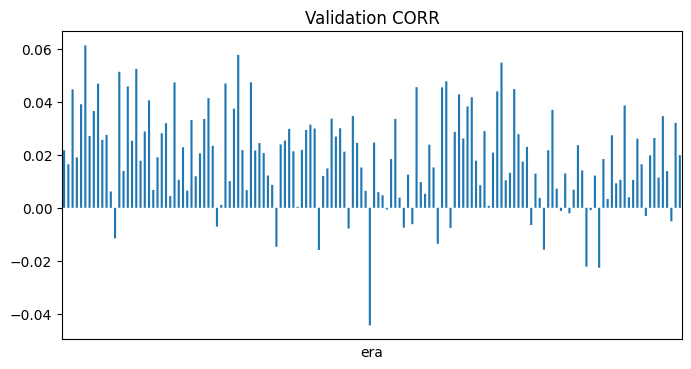

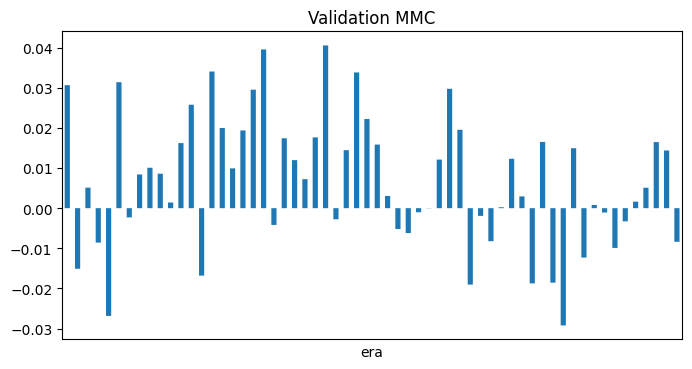

In [23]:
# Compute the per-era corr between our predictions and the target values
per_era_corr = validation.groupby("era").apply(
    lambda x: numerai_corr(x[["prediction"]].dropna(), x["target"].dropna())
)

# Compute the per-era mmc between our predictions, the meta model, and the target values
per_era_mmc = validation.dropna().groupby("era").apply(
    lambda x: correlation_contribution(x[["prediction"]], x["meta_model"], x["target"])
)


# Plot the per-era correlation
per_era_corr.plot(
  title="Validation CORR",
  kind="bar",
  figsize=(8, 4),
  xticks=[],
  legend=False,
  snap=False
)
per_era_mmc.plot(
  title="Validation MMC",
  kind="bar",
  figsize=(8, 4),
  xticks=[],
  legend=False,
  snap=False
)

Instead of looking at the raw score for each era, it is helpful to look at the cumulative scores.

If you are familiar with "backtesting" in quant finance where people simulate the historical performance of their investment strategies, you can roughly think of this plot as a backtest of your model performance over the historical validation period.

Notice a few things below:

- CORR gradually increases over many eras of the validation data even with this simple model on modern data.

- MMC is generated over a smaller set of recent eras - this is because the validation time range pre-dates the Meta Model.

- MMC is very high early on in the Meta Model's existence, MMC - this is because the newest datasets were not available and models trained on the newest data are could have been very additive in the past.

- MMC is flat and decreasing recently because the Meta Model has started catching up to modern data sets and getting correlation has been difficult in recent eras.

<Axes: title={'center': 'Cumulative Validation MMC'}, xlabel='era'>

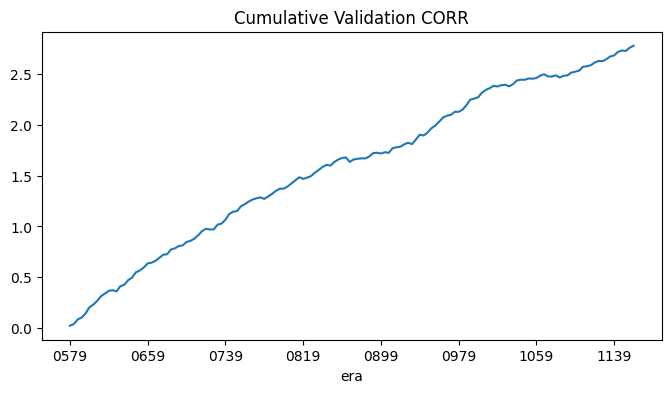

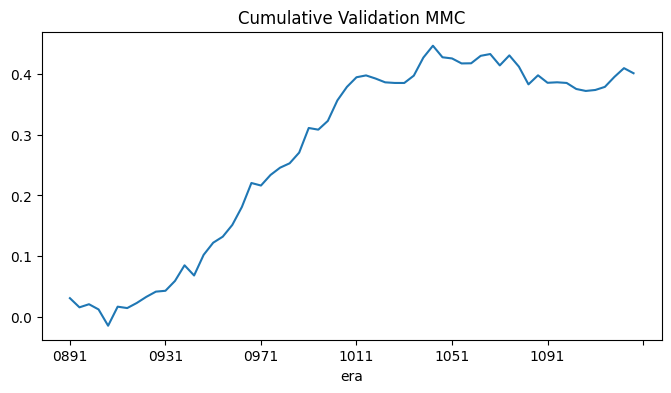

In [24]:
# Plot the cumulative per-era correlation
per_era_corr.cumsum().plot(
  title="Cumulative Validation CORR",
  kind="line",
  figsize=(8, 4),
  legend=False
)
per_era_mmc.cumsum().plot(
  title="Cumulative Validation MMC",
  kind="line",
  figsize=(8, 4),
  legend=False
)

### Performance metrics

To evaluate the performance of our model, it is also helpful to compute some summary metrics over the entire validation period:

- `Mean` is the primary measure of your model's long-term performance.

- `Sharpe` is a measure of your model's consistency. In finance, the Sharpe ratio of an investment strategy measures risk adjusted returns. In Numerai, we compute sharpe as the mean divided by the standard deviation.

- `Max drawdown` is a measure of your model's risk. In finance, the max drawdown of an investment strategy is the largest loss suffered. In Numerai, we compute max drawdown as the maximum peak to trough drop in a cumulative score.

In [25]:
# Compute performance metrics
corr_mean = per_era_corr.mean()
corr_std = per_era_corr.std(ddof=0)
corr_sharpe = corr_mean / corr_std
corr_max_drawdown = (per_era_corr.cumsum().expanding(min_periods=1).max() - per_era_corr.cumsum()).max()

mmc_mean = per_era_mmc.mean()
mmc_std = per_era_mmc.std(ddof=0)
mmc_sharpe = mmc_mean / mmc_std
mmc_max_drawdown = (per_era_mmc.cumsum().expanding(min_periods=1).max() - per_era_mmc.cumsum()).max()

pd.DataFrame({
    "mean": [corr_mean, mmc_mean],
    "std": [corr_std, mmc_std],
    "sharpe": [corr_sharpe, mmc_sharpe],
    "max_drawdown": [corr_max_drawdown, mmc_max_drawdown]
}, index=["CORR", "MMC"]).T

,CORR,MMC
mean,prediction 0.019042 dtype: float64,prediction 0.006691 dtype: float64
std,prediction 0.017999 dtype: float64,prediction 0.016217 dtype: float64
sharpe,prediction 1.057944 dtype: float64,prediction 0.412581 dtype: float64
max_drawdown,prediction 0.04435 dtype: float64,prediction 0.074557 dtype: float64


These performance metrics above are not amazing but that's ok, we are just getting started. In the next few tutorials, you will learn how to improve our model performance.

## 3. Submissions

Unlike Kaggle competitions that evalute models based on <ins>test</ins> performance, Numerai evaluates models based based on <ins>live</ins> performance.

### Live predictions

Every Tuesday-Saturday, new `live features` are released, which represent the current state of the stock market.

Your task is to generate `live predictions` on the unknown target values, which represent stock market returns 20 days into the future.

In [26]:
# Download latest live features
napi.download_dataset(f"{DATA_VERSION}/live.parquet")

# Load live features
live_features = pd.read_parquet(f"{DATA_VERSION}/live.parquet", columns=feature_set)

# Generate live predictions
live_predictions = model.predict(live_features[feature_set])

# Format submission
pd.Series(live_predictions, index=live_features.index).to_frame("prediction")

v5.0/live.parquet: 7.88MB [00:01, 4.65MB/s]                            


,prediction
id,
n000c3696cf45891,0.497184
n00192f7e319d555,0.486573
n001fc4571cdc549,0.504895
n00299ca2dac2f10,0.494468
n0043bb3a2d1dc9d,0.513990
...,...
nffa7f4c88922e1b,0.501612
nffd175a6f72dd5b,0.494920
nffd18070e217413,0.492717


### Model upload

To participate in the tournament, you must submit live predictions every Tuesday-Saturday.

To automate this process, you can simply:
- Define your prediction pipeline as a function
- Serialize your function using the `cloudpickle` library
- Upload your model pickle file to Numerai
- Let Numerai run your model to submit live predictions every day

Read more about Model Uploads and other self-hosted automation options in our [docs](https://docs.numer.ai/numerai-tournament/submissions#automation).


In [32]:
# Define your prediction pipeline as a function
def predict(live_features: pd.DataFrame) -> pd.DataFrame:
    live_predictions = model.predict(live_features[feature_set])
    submission = pd.Series(live_predictions, index=live_features.index)
    return submission.to_frame("prediction")

In [33]:
# Use the cloudpickle library to serialize your function
import cloudpickle
p = cloudpickle.dumps(predict)
with open("hello_numerai.pkl", "wb") as f:
    f.write(p)

# this uploads the pickle to your Numerai account for live predictions

In [44]:
# 0) Install any missing deps (run once in your env)
# !pip install -q numerapi cloudpickle pandas

import os
import cloudpickle
import pandas as pd
from numerapi import NumerAPI
from google.colab import userdata

# 1) Define your prediction pipeline
def predict(
    live_features: pd.DataFrame,
    live_benchmark_models: pd.DataFrame  # Numerai will pass this in, you can ignore or use it
) -> pd.DataFrame:
    # assume `final_model` and `feature_set` are already defined in your session
    X_live = live_features[feature_set]
    preds = model.predict(X_live)
    return pd.Series(preds, index=live_features.index).to_frame("prediction")

# 2) Serialize with cloudpickle
with open("predict.pkl", "wb") as f:
    cloudpickle.dump(predict, f)

# 3) Authenticate your NumerAPI client
# Option A: via environment variables
#    export NUMERAI_PUBLIC_ID="your_public_id"
#    export NUMERAI_SECRET_KEY="your_secret_key"
# Option B: directly in code:
napi = NumerAPI(public_id=userdata.get('NUMERAI_PUBLICID'), secret_key=userdata.get('NUMERAI_SECRET'))


# 4) (Optional) List available model slots, data versions, and docker images
#    Replace "my_model_name" with the name you registered on Numerai’s Models page.
models = napi.get_models()
print("Registered models:", models)
data_versions = napi.model_upload_data_versions()
docker_images = napi.model_upload_docker_images()
print("Data versions:", list(data_versions)[:3], "…")
print("Docker images:", list(docker_images)[:3], "…")

# 5) Upload your pickle
upload_id = napi.model_upload(
    file_path="predict.pkl",
    model_id=models["krrish33"],    # or use a literal model_id string
    data_version=data_versions[max(data_versions)],  # pick the latest data version
    docker_image=docker_images["Python 3.11"],     # pick your Python version
)
print(f"✅ Model uploaded! Upload ID: {upload_id}")

# Once this runs, Numerai will invoke your `predict` every Tue–Sat on live data.


Registered models: {'krrish33': 'd862f117-55e2-4c8b-bfe2-67a1c3f0b47b'}
Data versions: ['v5.0', 'v5.0 (no diagnostics)'] …
Docker images: ['Python 3.10', 'Python 3.11', 'Python 3.9'] …
✅ Model uploaded! Upload ID: 1e5326df-34de-4a62-98c3-d8187ed80833


In [39]:
models = napi.get_models()
print(models)

{'krrish33': 'd862f117-55e2-4c8b-bfe2-67a1c3f0b47b'}


In [29]:
# Download file if running in Google Colab
try:
    from google.colab import files
    files.download('hello_numerai.pkl')
except:
    pass

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

That's it! You now have a pickle file that is ready for upload.

Head back to the [Hello Numerai Tutorial](https://numer.ai/tutorial/hello-numerai) to upload your model!